In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure import plotter
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [12]:
mp_key = "kUNltwLCR9AdLypQdV0AJRVJ3G9Yb7B8"
mp_id = "mp-8426"

In [13]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

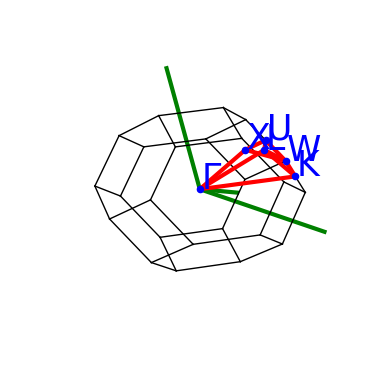

In [14]:
# Visualisation de la zone de brillouin

PhononBSPlotter(ph_bs).plot_brillouin()

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{Frequencies\\ (THz)}$'>

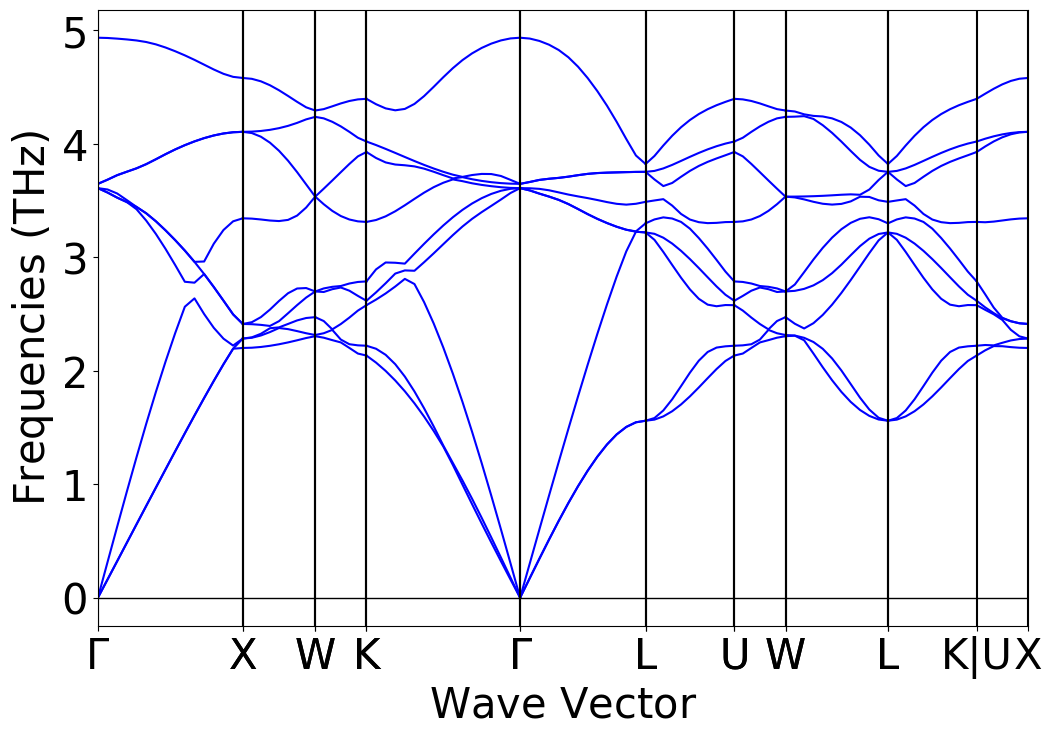

In [15]:
# Visualisation de la structure de bande de phonons

PhononBSPlotter(ph_bs).get_plot()

### Identification des bandes acoustiques

La première chose à déterminer est de savoir quelles sont les bandes accoustiques. Celles-ci correspondent aux bandes où la fréquence du phonon associée est nulle au centre de la zone de Brillouin. Nous avons donc trois possibilités: les directions $\Gamma-X$, $K-\Gamma$ et $\Gamma-L$.

### Calcul de la vitesse du son

Dans un solide, la vitesse de propagation du son correspond à la propagation d'un phonon dans le réseau réciproque (et donc la zone de Brillouin). Cette vitesse étant anisotrope, on peut s'attendre à voir des changements importants entre les vitesses déterminées pour chaque direction.

La vitesse du son est liée au vecteur d'onde **q** par la relation suivante: $$v_s = \frac{d\omega}{dq}$$ où $\omega$ est la relation de dispersion de notre matériau en posant comme hypothèse que nous sommes dans le cas de grande longueur d'onde ($\lambda$ >> **a**, où **a** est le paramètre de maille) afin d'avoir une relation linéaire. Pour obtenir la vitesse du son, il faut trouver la pente de cette approximation linéaire pour de petits vecteurs d'onde **q** sur notre diagramme de bandes précédent. Etant donné que le diagramme nous donne des fréquences en TerraHertz, il va falloir les convertir en Hz pour pouvoir obtenir $\omega$. Notre vecteur d'onde (actuellement en Angström) est également à modifier étant donné que nous souhaitons une vitesse en [m/s].

In [16]:
# Récupération des données

data = PhononBSPlotter(ph_bs).bs_plot_data()

frequency = data['frequency']
ticks = data['ticks']
distances = data['distances']

## Première bande acoustique : $\Gamma-X$

In [17]:
# Première direction

vitesse_son_1 = 2*np.pi*np.abs((frequency[0][1][1]-frequency[0][1][0])*(10**12))/((distances[0][1]-distances[0][0])*(10**10))
print("La vitesse du son dans la direction Gamma - X vaut {} m/s.".format(vitesse_son_1))

La vitesse du son dans la direction Gamma - X vaut 1839.8013921475074 m/s.


## Deuxième bande acoustique : $K-\Gamma$

In [18]:
# Deuxième direction

vitesse_son_2 = 2*np.pi*np.abs((frequency[3][0][-1] - frequency[3][0][-2])*(10**12))/((distances[3][-1]-distances[3][-2])*(10**10))
print("La vitesse du son dans la direction K - Gamma vaut {} m/s.".format(vitesse_son_2))

La vitesse du son dans la direction K - Gamma vaut 1841.6416068049557 m/s.


## Troisième bande acoustique : $\Gamma-L$

In [19]:
#Troisième direction

vitesse_son_3 = 2*np.pi*np.abs((frequency[4][2][1]-frequency[4][2][0])*(10**12))/((distances[4][1]-distances[4][0])*(10**10))
print("La vitesse du son dans la direction Gamma - L vaut {} m/s.".format(vitesse_son_3))

La vitesse du son dans la direction Gamma - L vaut 3446.9704937862234 m/s.


### Analyse des résultats

Les bandes $\Gamma-X$ et $K-\Gamma$ sont associées à des vitesses très similaires tandis que la bande $\Gamma-L$ est associée à une vitesse beaucoup plus élevée. Ce n'est pas un résultat aberrant car comme expliqué au début du notebook, nous pouvions nous attendre à des variations importantes de vitesse dues à son caractère anisotrope. 

Les résultats sont cohérents car la vitesse du son dans le cristal doit être supérieure à la vitesse dans l'air (340m/s) et dans l'eau (1500m/s).